## What type of cloud is this?

In [2]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

## Step 1: Data Preparation

**Different types of clouds:**

1. High Clouds (above 20,000 feet or 6,096 meters):

- Cirrus (Ci): Thin, wispy, and feathery clouds composed of ice crystals, often appearing at high altitudes.

- Cirrocumulus (Cc): Small, white patches or ripples, often appearing in sheets or layers, also composed of ice crystals.

- Cirrostratus (Cs): Thin, sheet-like clouds that can cover the entire sky, sometimes causing halos around the sun or moon, also composed of ice crystals. 

2. Middle Clouds (between 6,500 and 20,000 feet or 1,981 and 6,096 meters):

- Altocumulus (Ac): Mid-level clouds that appear as white or grayish patches, sometimes with a wavy or rippled appearance.

- Altostratus (As): Gray or bluish-gray, widespread, sheet-like clouds that can cover the entire sky, composed of water droplets and ice crystals.

- Nimbostratus (Ns): Dark, gray, and rain-bearing clouds that can cover the sky, composed of water droplets and ice crystals.

3. Low Clouds (below 6,500 feet or 1,981 meters):

- Stratus (St): Gray or whitish, sheet-like clouds that cover the entire sky, composed of water droplets.

- Stratocumulus (Sc): Low, gray or whitish clouds that appear as rounded masses or rolls, composed of water droplets.

- Cumulus (Cu): Puffy, cotton-like clouds with flat bases, composed of water droplets.

- Cumulonimbus (Cb): Large, towering clouds that can produce thunderstorms, heavy rain, and hail, composed of water droplets and ice crystals. 


In [4]:
from duckduckgo_search import DDGS 
from fastcore.all import *

def search_images(keywords, max_images=200): 
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [5]:
urls = search_images('cumulonimbus photos', max_images=1)
urls[0]

'https://cdn.pixabay.com/photo/2015/03/29/14/50/cumulonimbus-697288_1280.jpg'

beatiful

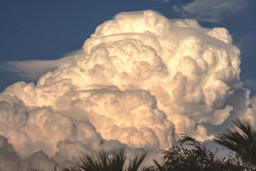

In [6]:
from fastdownload import download_url
dest = 'cumulonimbus.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

### Download 200 image for each cloud type


In [15]:
cloud_types = 'cirrus','cirrocumulus','cirrostratus','altocumulus','altostratus','nimbostratus','stratus','stratocumulus','cumulus','cumulonimbus'
path = Path('photos')
from time import sleep

# for o in cloud_types:
#     dest = (path/o)
#     dest.mkdir(exist_ok=True, parents=True)
#     download_images(dest, urls=search_images(f'{o} photo'))
#     sleep(10)  # Pause between searches to avoid over-loading server
#     resize_images(path/o, max_size=400, dest=path/o)

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [18]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

44

## Step 2: Train our model

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [16]:
path

Path('photos')

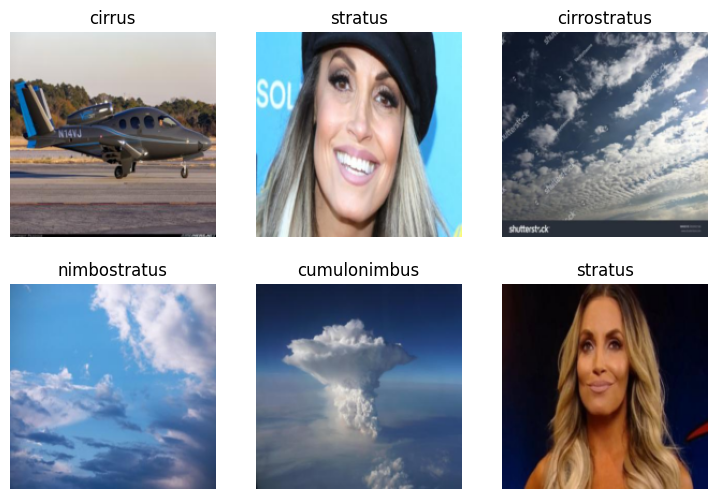

In [20]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here is what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.606847,0.776637,0.240000,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.114463,0.045450,0.026667,00:03
1,0.065541,0.009315,0.000000,00:02
2,0.043300,0.007967,0.000000,00:02


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.